In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

Loading imports


In [2]:
torch.cuda.set_device(4)

In [3]:
dbunch_feat = get_3d_dbunch_feat(Meta.df_any, path_feat256, bs=64)

In [4]:
x,y = dbunch_feat.one_batch()
x.shape, y.shape

(torch.Size([64, 60, 512, 8, 8]), torch.Size([64, 60, 6]))

## Model

In [5]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            ConvLayer(512, 512, stride=2),
            ConvLayer(512, 1024, stride=2),
            ConvLayer(1024, 2048, stride=2),
            Flatten()
        )
        self.hook = ReshapeBodyHook(self.conv)
        hidden = 96
        self.lstm = nn.LSTM(input_size=2048, hidden_size=hidden, num_layers=2, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden*2,hidden*4),
            nn.ReLU(),
            nn.Linear(hidden*4,6)
        )
        
    def forward(self, x):
        x = self.conv(x)
        feat, _ = self.lstm(x)
        return self.head(feat)

In [6]:
m = SeqHead().cuda()

In [7]:
learn = get_learner(dbunch_feat, m)

In [8]:
learn.add_cb(DePadLoss())

In [9]:
# learn.load(f'runs/baseline_any-2b', strict=False)

In [10]:
# learn.summary()

## Training

In [11]:
name = 'trainSeq_baseline_lstm'

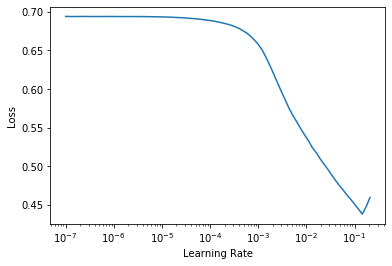

In [12]:
learn.lr_find()

In [ ]:
do_fit(learn, 20, 5e-2, freeze=False)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
